In [4]:
%matplotlib notebook
import numpy as np
from numpy.linalg import norm as norm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import math as m
from scipy.special import hankel1 as hankel
from scipy.interpolate import interp1d
import scipy.constants as c
import time
import matplotlib.pyplot as plt

# folder = 'C:/Users/jabuk/Documents/jaderka/diplomka/images_jup/'
folder = ''

yellow='#ffb200'
red='#DD5544'
blue='#0284C0'

In [5]:
class Permeability():
    def __init__(self):
        f= open('gold_pcgrate.txt', 'r')
        contents=f.readlines()

        self.wavelength=[]
        self.epsilon=[]
        self.real=[]
        self.imag=[]

        for line in contents[:-1]:
            line_split=line.split('\t')
            if 0.3<float(line_split[0])<1.5:
                self.wavelength.append(float(line_split[0])/1e6)
                
                eps=(float(line_split[1])+1j*float(line_split[2]))**2
                self.epsilon.append(eps)
                self.real.append(np.real(eps))
                self.imag.append(np.imag(eps))
        
        k=3
        self.sreal=interp1d(self.wavelength, self.real, kind='linear')
        self.simag=interp1d(self.wavelength, self.imag, kind='linear')

    def eps(self, lm):
        return self.sreal(lm)+1j*self.simag(lm)
    
metal=Permeability()

$\beta = [\frac{R_p}{2z_p}]^3$ 

$a = \sqrt{\frac{\epsilon_r}{-\epsilon_m}}$

$\alpha_e = \frac{6ak_0^3\epsilon_r^{3/2}V_p(\epsilon_p - \epsilon_r)}{\epsilon_p + 2\epsilon_r - 2(\epsilon_p - \epsilon_r)\beta}$

polarizability of a spherical nanoparticle in homogenious environment is:  
$\alpha = 3\epsilon_0V\frac{\epsilon(\omega) - \epsilon_m}{\epsilon(\omega) + 2\epsilon_m}$

relation of the cross-section to the effective plarizability [Bozhevolnyi]  
$\sigma = \frac{\alpha^2}{4Re\{\beta\}}$

In [6]:
def alpha(epsm, eps, d):
    #http://downloads.hindawi.com/journals/jnm/2007/045090.pdf
    V = 1/6*m.pi*d**3
    alpha = 3 * c.epsilon_0 * V * (eps - epsm)/(eps + 2 * epsm)
    return alpha
    
def alpha_eff(ed, em, ep, r, z, lm):
    em = em
    er = ed
    k0 = 2*m.pi/lm
    a = (er/(-em))**0.5
        
    V = 4*m.pi*r**3/3    
    beta = (r/2/z)**3
    out = (6*a*k0**3*er**(3/2)*V*(ep-er))/(ep + 2*er - 2*(ep-er) * beta)
    return out

def betavector(lm):
    k0=2*m.pi/lm
    epd=1.33**2 #water
    epm=metal.eps(lm)
    epm=epm.conjugate()
    epp=epd*epm/(epd+epm)
    beta=k0*(epp**0.5)
    return beta

def U(k, x):
    U0 = 1
    return U0*np.exp(1j*np.dot(np.real(k), x))

def Udiff(k, r, x):
    rr=norm(x-r)
    p=np.dot(x-r, np.array([1,0]))/rr #scalar product disabling SPP with k perpendicular to original SPP
    if rr==0:
        return 0.2
    return 0.2*U(k, r)*np.exp(1j*rr*norm(np.real(k)))*p*np.exp(-norm(np.imag(k))*rr)#/((rr+2.93e6)**0.5)

def intensity(u):
    return u*np.conjugate(u)

def Pattern(alpha, ed, em, ep, r, z, lm, r0, x):

    k0 = 2*m.pi/lm
    epp = ed*em/(ed+em)
    
    beta = k0*(epp**0.5)
    k = np.array([beta, 0])
    
    rr=norm(x-r0)
    p=np.dot(x-r0, np.array([1,0]))/rr #scalar product disabling SPP with k perpendicular to original SPP
    back = intensity(U(-k,x)+alpha * U(-k,r0)*1j/4*hankel(0, beta*np.linalg.norm(x - r0)))
    forward = intensity(U(k,x)+alpha* U(k,r0)*1j/4*hankel(0, beta*np.linalg.norm(x - r0)))
    
    return back+forward


#### Decoupling of the scattered light

What is the maximal angle of the wavevector relatively to the grating vector that can be captured by imaging optics when decoupled?

According to the couping condition and the grating equation:

$\beta = mK + k\sin\Theta$

For the projection of the wavevector of the scattered wave it applies, that:

$\beta_{ext} = mK +kNA$

And so the extremal angle is:

$\gamma = \arccos\frac{mK + kNA}{\beta}$

In the case when $\lambda = 750$ nm  
For NA = 0.16:  
$\gamma = 27.7^\circ$

For NA = 0.22:  
$\gamma = 32.7^\circ$

For NA = 0.59 (Zybin):  
$\gamma = 54.9^\circ$

In the case when $\lambda = 600$ nm  
For NA = 0.16:  
$\gamma = 26.9^\circ$

For NA = 0.22:  
$\gamma = 31.6^\circ$

For NA = 0.59 (Zybin):  
$\gamma = 53^\circ$


In [21]:
lm = 750e-9
beta = betavector(lm).real
K = beta
k = 2*m.pi/lm
NA = 0.59

gamma = 180 - m.acos((k*NA - K)/beta)/m.pi*180
print(gamma)

54.87594523072572


## Effective polarizability
$\lambda = 750 nm$  
AuNP, r = 50nm, z = 50nm => $\alpha_{eff} = 2.42$  
PSNP, r = 50nm, z = 50nm => $\alpha_{eff} = 0.16$  
$\frac{\alpha_{Au}}{\alpha_{PS}} = 15.1$  


In [4]:
2.42/0.16

15.125

In [5]:
lm = 727e-9
alpha = alpha_eff(ed = 1.33**2,
                em = metal.eps(lm),
                ep = metal.eps(lm),
                r = 40e-9, 
                z = 40e-9, 
                lm = lm).real
print(alpha)
sigma = alpha**2/betavector(lm).real/4
print(sigma*1e7)

1.524470224527616
0.4810292075686741


<IPython.core.display.Javascript object>


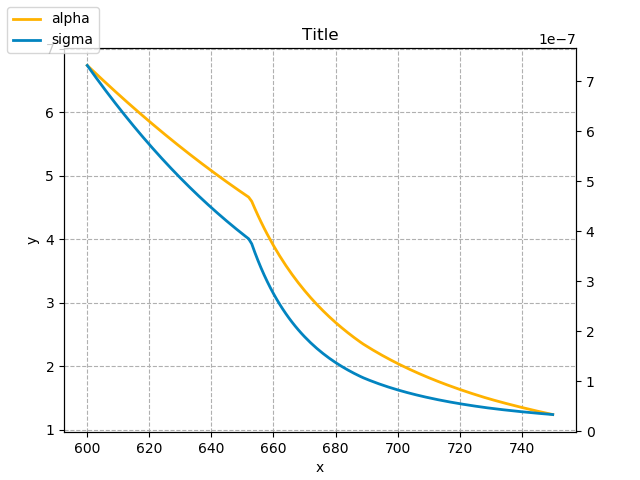

In [8]:
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.grid(linestyle='--')
axes.set_title('Title')
axes.set_xlabel('x')
axes.set_ylabel('y')
axesII = axes.twinx()

lms = np.arange(600e-9, 750e-9, 1e-9)
fn_alpha = lambda x: alpha_eff(ed = 1.33**2,
                               em = metal.eps(x),
                               ep = metal.eps(x),
                               r = 40e-9, 
                               z = 40e-9, 
                               lm = x).real

alphas =  fn_alpha(lms)
betas = betavector(lms)

sigmas = [fn_alpha(l)**2/betavector(l).real/4 for l in lms]

name='test_01'
axes.plot(lms*1e9, alphas, color=yellow, linewidth=2, label='alpha')
axesII.plot(lms*1e9, sigmas, color=blue, linewidth=2, label='sigma')
fig.legend(loc=2)
# fig.savefig('jupyter_plots/' + name + '.png', dpi=300)

<IPython.core.display.Javascript object>


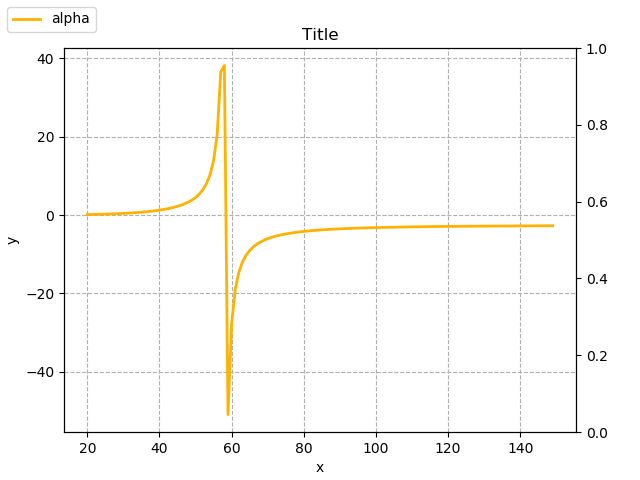

In [9]:
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.grid(linestyle='--')
axes.set_title('Title')
axes.set_xlabel('x')
axes.set_ylabel('y')
axesII = axes.twinx()

rs = np.arange(20e-9, 150e-9, 1e-9)
fn_alpha = lambda x: alpha_eff(ed = 1.33**2,
                               em = metal.eps(750e-9),
                               ep = metal.eps(750e-9),
                               r = x, 
                               z = 40e-9, 
                               lm = 750e-9).real

alphas =  fn_alpha(rs)
beta = betavector(750e-9)

# sigmas = alphas**2/beta.real/4

name='test_01'
axes.plot(rs*1e9, alphas, color=yellow, linewidth=2, label='alpha')
# axesII.plot(rs*1e9, sigmas, color=blue, linewidth=2, label='sigma')
fig.legend(loc=2)
# fig.savefig('jupyter_plots/' + name + '.png', dpi=300)

In [50]:
time_start = time.time()
px = 2.93*1e-7
# px = 2.93*1e-6
# X=np.arange(0,200*px, px)
# Y=np.arange(0,200*px, px)
# r=np.array([100,100])*px
lm = 750e-9
X=np.arange(0,1000*px, px)
Y=np.arange(0,1000*px, px)
r=np.array([500,500])*px

data_ps=np.zeros([len(Y),len(X)])
data_au=np.zeros([len(Y),len(X)])
data_back=np.zeros([len(Y),len(X)])

alpha_ps = alpha_eff(ed = 1.33**2,
                  em = metal.eps(lm),
                  ep = 1.58**2,
                  r = 50e-9, 
                  z = 50e-9, 
                  lm = lm).real

alpha_au = alpha_eff(ed = 1.33**2,
                  em = metal.eps(lm),
                  ep = metal.eps(lm),
                  r = 50e-9, 
                  z = 50e-9, 
                  lm = lm).real

for i in range(len(Y)):
    for j in range(len(X)):
        x=X[j]
        y=Y[i]

        data_ps[i,j] = Pattern(
            alpha = alpha_ps,
            ed = 1.33**2,
            em = metal.eps(lm),
            ep = 1.58**2,
            r = 50e-9, 
            z = 50e-9, 
            lm = lm,
            r0 = r, 
            x = np.array([x,y])
        )

        data_au[i,j] = Pattern(
            alpha = alpha_au,
            ed = 1.33**2,
            em = metal.eps(lm),
            ep = metal.eps(lm),
            r = 50e-9, 
            z = 50e-9, 
            lm = lm,
            r0 = r, 
            x = np.array([x,y])
        )
        
print('ELAPSED TIME: {:.2f} s'.format(time.time()-time_start))

In [13]:
def resize(data, n):
    shape = (data.shape[0]//n, data.shape[1]//n)
    out = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):        
            out[i, j] = np.sum(data[i*n:(i + 1)*n, j*n:(j+ 1)*n])
    return out - 2*n**2

In [52]:
print(alpha_au)
print(alpha_ps)
print(alpha_au/alpha_ps)

2.4222191337712125
0.1563710891657339
15.490198007151832


<IPython.core.display.Javascript object>


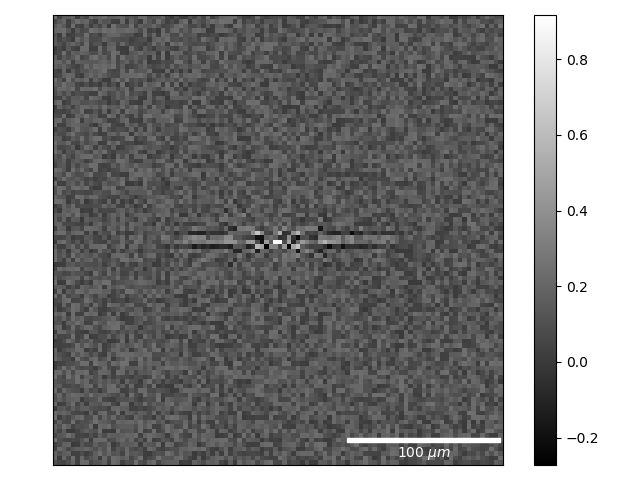

(-0.2726221267832182, 0.9171370718254456)


In [66]:
fig, ax = plt.subplots()

image_au = resize(data_au, 10)
image_ps = resize(data_ps, 10)
background = np.random.rand(100, 100)*np.sum(np.nan_to_num(np.abs(image_au)))/16/4/4
img = ax.imshow(image_au+ background)


# img = ax.imshow(data_au)
plt.set_cmap('gray')

fig.colorbar(img)
# ax.set_title('Interference pattern', fontsize=16)



fontprops = fm.FontProperties(size=10)
scalebar = AnchoredSizeBar(ax.transData,
           34, '100 $\mu m$', 'lower right', 
           pad=0.1,
           color='white',
           frameon=False,
           size_vertical=1,
           fontproperties=fontprops)

ax.add_artist(scalebar)

for tick in ax.get_yticklines():
    tick.set_visible(False)
for tick in ax.get_yticklabels():
    tick.set_visible(False)
for tick in ax.get_xticklines():
    tick.set_visible(False)
for tick in ax.get_xticklabels():
    tick.set_visible(False)
# img.set_clim(-5, 5)
plt.tight_layout()      
# fig.savefig(folder + 'hankel_interference_ps.png', dpi = 300)
print(img.get_clim())

In [27]:
image.shape

(100, 100)

In [33]:
px = 5*1e-8
X=np.arange(0,200*px, px)
Y=np.arange(0,200*px, px)

r=np.array([100,100])*px
alpha = 3


data=np.zeros([len(Y),len(X)])

for i in range(len(Y)):
    for j in range(len(X)):
        x=X[j]
        y=Y[i]
#         data[i,j]=intensity(U(k,np.array([x,y])))
#         data[i,j] = intensity(U(k,np.array([x,y]))+alpha* U(k,r)*1j/4*hankel(0, beta*np.linalg.norm(np.array([x, y]) - r)))
        data[i,j] = hankel(0, beta*np.linalg.norm(np.array([x, y]) - r))
        
#         data[i,j] = intensity(data[i,j])
        





C:\Users\Bukacek\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


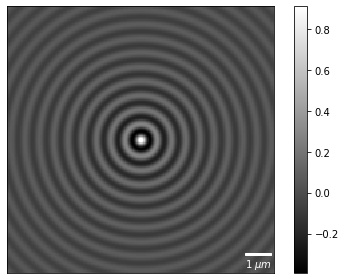

In [34]:
fig, ax = plt.subplots()
img = ax.imshow(data)
plt.set_cmap('gray')

fig.colorbar(img)
# ax.set_title('$\mathcal{R}\{H_0^{1}\}$', fontsize=16)



fontprops = fm.FontProperties(size=10)
scalebar = AnchoredSizeBar(ax.transData,
           34*2.93/px/1e8, '1 $\mu m$', 'lower right', 
           pad=0.1,
           color='white',
           frameon=False,
           size_vertical=1,
           fontproperties=fontprops)

ax.add_artist(scalebar)

for tick in ax.get_yticklines():
    tick.set_visible(False)
for tick in ax.get_yticklabels():
    tick.set_visible(False)
for tick in ax.get_xticklines():
    tick.set_visible(False)
for tick in ax.get_xticklabels():
    tick.set_visible(False)
    
plt.tight_layout()      
# fig.savefig(folder + 'hankel_real.png', dpi = 300)
# ,clim=(0, 20)

ValueError: x and y must have same first dimension, but have shapes (200,) and (500,)

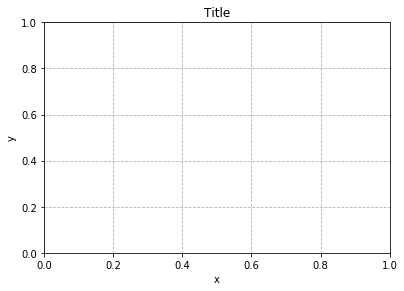

In [32]:
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.grid(linestyle='--')
axes.set_title('Title')
axes.set_xlabel('x')
axes.set_ylabel('y')

x = np.arange(1,10,0.2)
y = x**2 

name='test_01'
axes.plot(X*2.93e6,data[50,:], color=yellow, linewidth=2, label='x')
# axes.plot(x, x**3, color=blue, linewidth=2, label='y')
axes.legend(loc=2)
# fig.savefig('jupyter_plots/' + name + '.png', dpi=300)